In [1]:
!pip install -q -r requirements.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipympl 0.8.7 requires ipywidgets<8,>=7.6.0, but you have ipywidgets 8.0.7 which is incompatible.
numba 0.55.0 requires numpy<1.22,>=1.18, but you have numpy 1.22.4 which is incompatible.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.22.4 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 4.11.0 which is incompatible.
torchaudio 0.10.2 requires torch==1.10.2, but you have torch 2.2.1 which is incompatible.


In [23]:
# !wget https://huggingface.co/Veldrovive/upsamplers/resolve/main/working/decoder_config.json?download=true -O upsampler/decoder_config.json
# !wget https://huggingface.co/laion/DALLE2-PyTorch/raw/main/prior/prior_config.json -O upsampler/prior_config.json
# !wget https://huggingface.co/laion/DALLE2-PyTorch/resolve/main/prior/best.pth -O upsampler/prior.pth
# !wget https://huggingface.co/Veldrovive/upsamplers/resolve/main/working/latest.pth?download=true -O upsampler/decoder.pth

In [2]:
import json
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from dalle2_pytorch import (
    DiffusionPrior,
    DiffusionPriorNetwork,
    OpenAIClipAdapter,
    train_configs,
)
from dalle2_pytorch.tokenizer import tokenizer
from einops import rearrange, repeat
from PIL import Image
from torch import einsum, nn
from tqdm.auto import tqdm
from transformers import pipeline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
with open("upsampler/decoder_config.json", 'r') as f:
    config = json.load(f)
config = train_configs.DecoderConfig(**config)
decoder = config.create().to(device)
decoder.load_state_dict(torch.load("upsampler/decoder.pth", map_location='cpu'), strict=True)
decoder = decoder.eval()
decoder.sample_timesteps = (50, 50)

100%|███████████████████████████████████████| 933M/933M [01:08<00:00, 13.6MiB/s]


In [6]:
config = train_configs.TrainDiffusionPriorConfig.from_json_path("upsampler/prior_config.json")
prior = config.prior.create().to(device)
prior.load_state_dict(torch.load("upsampler/prior.pth", map_location="cpu"), strict=True)
prior = prior.eval()
!rm upsampler/prior.pth

In [7]:
for p in prior.parameters():
    p.requires_grad = False

for p in decoder.parameters():
    p.requires_grad = False

In [8]:
def _transform(n_px):
    return transforms.Compose([
        transforms.Resize((n_px, n_px), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ])

tensor_to_pil = torchvision.transforms.ToPILImage()

In [10]:
tokenized_text = tokenizer.tokenize("A blue bird").to(device)

In [20]:
with torch.no_grad():
    prior_embeddings = prior.sample(tokenized_text, num_samples_per_batch=2, cond_scale=1.0)
    text_embed, text_encodings = decoder.clip.embed_text(tokenized_text)
    img = decoder.sample(image_embed=prior_embeddings, text_encodings=text_encodings, cond_scale=7.5, stop_at_unet_number=1).squeeze()

sampling loop time step:   0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/50 [00:00<?, ?it/s]

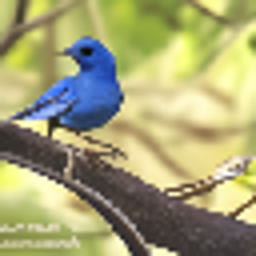

In [21]:
tensor_to_pil(img).resize((256, 256))

In [9]:
def l2norm(t):
    return nn.functional.normalize(t, dim=-1)


def resize_image_to(image, target_image_size):
    orig_image_size = image.shape[-1]
    if orig_image_size == target_image_size:
        return image
    out = nn.functional.interpolate(image, target_image_size, mode='nearest')
    out = out.clamp(0.0, 1.0)
    return out

In [10]:
class PreditorPrior:
    """Prior network from PRedItOR paper"""
    def __init__(self, prior, c=.7):
        self.prior = prior
        self.device = prior.device
        self.image_embed_dim = prior.image_embed_dim
        self.condition_on_text_encodings = prior.condition_on_text_encodings
        self.image_embed_scale = prior.image_embed_scale
        self.num_timesteps = int(prior.noise_scheduler.num_timesteps * c)
        self.preprocess = _transform(224)

    @torch.no_grad()
    def p_sample(self, x, t, text_cond, cond_scale=1.):
        """Переопределяем метод исходного класса prior"""
        b = x.shape[0]
        model_mean, _, model_log_variance = self.prior.p_mean_variance(x=x, t=t, text_cond=text_cond, clip_denoised=True, cond_scale=cond_scale)
        noise = torch.randn_like(x)
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    @torch.no_grad()
    def p_sample_loop(self, batch_size, image_embed, text_cond, cond_scale=1.):
        """Переопределяем метод исходного класса prior"""
        device = self.device
        for i in tqdm(reversed(range(0, self.num_timesteps)), desc='prior', total=self.num_timesteps):
            t = torch.full((batch_size,), i, device=device, dtype=torch.long)
            image_embed = self.p_sample(image_embed, t, text_cond, cond_scale)
        return image_embed

    @torch.no_grad()
    def sample(self, image, text, num_samples_per_batch=2, cond_scale=1.):
        """Переопределяем метод исходного класса prior"""
        text = repeat(text, 'b ... -> (b r) ...', r=num_samples_per_batch)

        batch_size = text.shape[0]
        image_embed_dim = self.image_embed_dim

        # Используем CLIP embedding как стартовую точку вместо N(0, 1)
        image = self.preprocess(image).unsqueeze(0).to(self.device)
        image_embed, _ = self.prior.clip.embed_image(image)
        image_embed *= self.prior.image_embed_scale
        image_embed = repeat(image_embed, 'b ... -> (b r) ...', r=num_samples_per_batch)

        text_embed, text_encodings = self.prior.clip.embed_text(text)
        text_cond = dict(text_embed=text_embed)

        if self.condition_on_text_encodings:
            text_cond = {**text_cond, 'text_encodings': text_encodings}

        image_embeds = self.p_sample_loop(batch_size, image_embed, text_cond, cond_scale)

        image_embeds /= self.image_embed_scale

        text_embeds = text_cond['text_embed']

        text_embeds = rearrange(text_embeds, '(b r) d -> b r d', r=num_samples_per_batch)
        image_embeds = rearrange(image_embeds, '(b r) d -> b r d', r=num_samples_per_batch)

        text_image_sims = einsum('b r d, b r d -> b r', l2norm(text_embeds), l2norm(image_embeds))
        top_sim_indices = text_image_sims.topk(k=1).indices

        top_sim_indices = repeat(top_sim_indices, 'b 1 -> b 1 d', d=image_embed_dim)

        top_image_embeds = image_embeds.gather(1, top_sim_indices)
        return rearrange(top_image_embeds, 'b 1 d -> b d')

In [11]:
class PreditorDecoder:
    """Decoder network from PRedItOR paper"""
    def __init__(self, decoder, s, ddim_steps=50, image_embed_scale=27.712812921102035):
        self.device = decoder.device
        self.clip = decoder.clip
        self.decoder = decoder
        self.unets = decoder.unets
        self.noise_schedulers = decoder.noise_schedulers
        self.image_sizes = decoder.image_sizes
        self.learned_variance = decoder.learned_variance
        self.lowres_conds = decoder.lowres_conds
        self.input_image_range = decoder.input_image_range
        self.normalize_img = decoder.normalize_img
        self.unnormalize_img = decoder.unnormalize_img
        self.dynamic_threshold = decoder.dynamic_threshold
        self.preprocess_clip = _transform(224)
        self.preprocess_ddim = _transform(self.image_sizes[0])
        self.num_unets = len(self.unets)
        self.ddim_steps = ddim_steps
        self.image_embed_scale = image_embed_scale
        self.s = s # регулирует силу structure preservation

    @torch.no_grad()
    def p_sample_loop_ddim(
        self,
        unet,
        image_size,
        structural_embed,
        image_embed,
        text_encodings,
        cond_scale,
        learned_variance,
        lowres_cond_img,
        noise_scheduler,
        timesteps=50,
        upsample=False
    ):
        device, total_timesteps, alphas = self.device, noise_scheduler.num_timesteps, noise_scheduler.alphas_cumprod_prev

        if upsample:
            img = torch.randn((1, 3, image_size, image_size), device=device)
            eta = 1.0
        else:
            img = structural_embed
            eta = 0.5
            total_timesteps = int(total_timesteps * self.s)

        times = torch.linspace(0., total_timesteps, steps=timesteps+2)[:-1]
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:]))

        if lowres_cond_img is not None:
            lowres_cond_img = self.normalize_img(lowres_cond_img)

        for i, (time, time_next) in tqdm(enumerate(time_pairs), desc='decoder ddim', total=len(times)-1):
            alpha = alphas[time]
            alpha_next = alphas[time_next]

            time_cond = torch.full((1,), time, device=device, dtype=torch.long)
            
            pred = unet.forward_with_cond_scale(img, time_cond, image_embed=image_embed, text_encodings=text_encodings, cond_scale=cond_scale, lowres_cond_img=lowres_cond_img)

            if learned_variance:
                pred, _ = pred.chunk(2, dim=1)

            x_start = noise_scheduler.predict_start_from_noise(img, t=time_cond, noise=pred)
            pred_noise = pred.clone()

            x_start = self.dynamic_threshold(x_start)

            c1 = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c2 = ((1 - alpha_next) - torch.square(c1)).sqrt()
            noise = torch.randn_like(img) if time_next > 0 else 0.
            img = x_start * alpha_next.sqrt() + \
                  c1 * noise + \
                  c2 * pred_noise

        img = self.unnormalize_img(img)
        return img

    def sample(self, base_image, image_embed, text, cond_scale, upsample):
        _, text_encodings = self.clip.embed_text(text)
        structural_embed, latents = self.ddim_inverse(base_image)
        imgs = []
        img = self.p_sample_loop_ddim(
            self.unets[0],
            self.image_sizes[0],
            structural_embed=structural_embed,
            image_embed=image_embed,
            text_encodings=text_encodings,
            cond_scale=cond_scale,
            learned_variance=self.learned_variance[0],
            lowres_cond_img=None,
            noise_scheduler=self.noise_schedulers[0],
            upsample=False
        )
        imgs.append(img.clone().detach().squeeze())
        if upsample:
            lowres_cond_img = resize_image_to(img, self.image_sizes[1])
            img = self.p_sample_loop_ddim(
                self.unets[1],
                self.image_sizes[1],
                structural_embed=structural_embed,
                image_embed=image_embed,
                text_encodings=text_encodings,
                cond_scale=cond_scale,
                learned_variance=self.learned_variance[1],
                lowres_cond_img=lowres_cond_img,
                noise_scheduler=self.noise_schedulers[1],
                upsample=True
            )
            imgs.append(img.clone().detach().squeeze())
        return imgs[-1]

    @torch.no_grad()
    def ddim_inverse(self, x_0):
        """Reverse ddim process"""
        clip_emb = self.clip.embed_image(self.preprocess_clip(x_0).unsqueeze(0).to(self.device))[0]
        clip_emb *= self.image_embed_scale #?????
        x = self.preprocess_ddim(x_0).unsqueeze(0).to(self.device)
        unet = self.unets[0]
        noise_scheduler = self.noise_schedulers[0]
        learned_variance = self.learned_variance[0]

        times = torch.linspace(0., noise_scheduler.num_timesteps * self.s, steps=self.ddim_steps+2)[:-1] #подумать над временем
        times = list(times.int().tolist())
        time_pairs = list(zip(times[:-1], times[1:]))
        latents = [x.clone().detach()]
        for time, time_next in tqdm(time_pairs, desc='inverse ddim'):
            t = torch.full((1,), time, device=self.device, dtype=torch.long)
            next_t = torch.full((1,), time_next, device=self.device, dtype=torch.long)
            noise = unet(x, t, image_embed=clip_emb)
            if learned_variance:
                noise, _ = noise.chunk(2, dim=1)
            
            x = noise_scheduler.predict_start_from_noise(x, t, noise)
            x = self.dynamic_threshold(x)
            x = noise_scheduler.q_sample(x, next_t, noise)
            latents.append(x.clone().detach())
        return x, latents

In [38]:
class NullTextPreditorDecoder(PreditorDecoder):
    def __init__(self, decoder, s, ddim_steps=50, image_embed_scale=27.712812921102035):
        self.device = decoder.device
        self.clip = decoder.clip
        self.decoder = decoder
        self.unets = decoder.unets
        self.noise_schedulers = decoder.noise_schedulers
        self.image_sizes = decoder.image_sizes
        self.learned_variance = decoder.learned_variance
        self.lowres_conds = decoder.lowres_conds
        self.input_image_range = decoder.input_image_range
        self.normalize_img = decoder.normalize_img
        self.unnormalize_img = decoder.unnormalize_img
        self.dynamic_threshold = decoder.dynamic_threshold
        self.preprocess_clip = _transform(224)
        self.preprocess_ddim = _transform(self.image_sizes[0])
        self.num_unets = len(self.unets)
        self.ddim_steps = ddim_steps
        self.image_embed_scale = image_embed_scale
        self.s = s # регулирует силу structure preservation
        
        self.uncond_image_embed = self.unets[0].null_image_embed
        self.uncond_embeds = None

    @torch.no_grad()
    def p_sample_loop_ddim(
        self,
        unet,
        image_size,
        structural_embed,
        image_embed,
        text_encodings,
        cond_scale,
        learned_variance,
        lowres_cond_img,
        noise_scheduler,
        timesteps=50,
        upsample=False
    ):
        device, total_timesteps, alphas = self.device, noise_scheduler.num_timesteps, noise_scheduler.alphas_cumprod_prev

        if upsample:
            img = torch.randn((1, 3, image_size, image_size), device=device)
            eta = 1.0
        else:
            img = structural_embed
            eta = 0.0
            total_timesteps = int(total_timesteps * self.s)

        times = torch.linspace(0., total_timesteps, steps=timesteps+2)[:-1]
        times = list(reversed(times.int().tolist()))
        time_pairs = list(zip(times[:-1], times[1:]))

        if lowres_cond_img is not None:
            lowres_cond_img = self.normalize_img(lowres_cond_img)

        for i, (time, time_next) in tqdm(enumerate(time_pairs), desc='decoder ddim', total=len(times)-1):
            alpha = alphas[time]
            alpha_next = alphas[time_next]

            time_cond = torch.full((1,), time, device=device, dtype=torch.long)
            
            if not upsample:
                unet.null_image_embed = torch.nn.Parameter(self.uncond_embeds[i])
            pred = unet.forward_with_cond_scale(img, time_cond, image_embed=image_embed, text_encodings=text_encodings, cond_scale=cond_scale, lowres_cond_img=lowres_cond_img)

            if learned_variance:
                pred, _ = pred.chunk(2, dim=1)

            x_start = noise_scheduler.predict_start_from_noise(img, t=time_cond, noise=pred)
            pred_noise = pred.clone()

            x_start = self.dynamic_threshold(x_start)
            
            c1 = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c2 = ((1 - alpha_next) - torch.square(c1)).sqrt()
            noise = torch.randn_like(img) if time_next > 0 else 0.
            img = x_start * alpha_next.sqrt() + \
                  c1 * noise + \
                  c2 * pred_noise

        img = self.unnormalize_img(img)
        return img

    def sample(self, base_image, image_embed, text, cond_scale, upsample):
        _, text_encodings = self.clip.embed_text(text)
        structural_embed, latents = self.ddim_inverse(base_image)
        self.uncond_embeds = self.null_text_optimization(image_embed, latents, cond_scale=cond_scale)
        imgs = []
        img = self.p_sample_loop_ddim(
            self.unets[0],
            self.image_sizes[0],
            structural_embed=structural_embed,
            image_embed=image_embed,
            text_encodings=text_encodings,
            cond_scale=cond_scale,
            learned_variance=self.learned_variance[0],
            lowres_cond_img=None,
            noise_scheduler=self.noise_schedulers[0],
            upsample=False
        )
        imgs.append(img.clone().detach().squeeze())
        if upsample:
            lowres_cond_img = resize_image_to(img, self.image_sizes[1])
            img = self.p_sample_loop_ddim(
                self.unets[1],
                self.image_sizes[1],
                structural_embed=structural_embed,
                image_embed=image_embed,
                text_encodings=text_encodings,
                cond_scale=cond_scale,
                learned_variance=self.learned_variance[1],
                lowres_cond_img=lowres_cond_img,
                noise_scheduler=self.noise_schedulers[1],
                upsample=True
            )
            imgs.append(img.clone().detach().squeeze())
        return imgs[-1]
    
    def null_text_optimization(self, image_embed, latents, num_inner_steps=10, cond_scale=7.5, epsilon=1e-5):
        uncond_embeddings = []
        latent_cur = latents[-1]
        
        eta = 0.5
        noise_scheduler = self.noise_schedulers[0]
        unet = self.unets[0]
        learned_variance = self.learned_variance[0]
        
        bar = tqdm(total=num_inner_steps * self.ddim_steps, desc='null-text')
        times = torch.linspace(0., noise_scheduler.num_timesteps * self.s, steps=self.ddim_steps+2)[:-1]
        times = list(reversed(times.int().tolist()))
        alphas = noise_scheduler.alphas_cumprod_prev
        
        uncond_embedding = self.uncond_image_embed.clone().detach()
        for i in range(self.ddim_steps):
            t = torch.full((1,), times[i], device=self.device, dtype=torch.long)
            uncond_embedding = uncond_embedding.clone().detach()
            unet.null_image_embed = torch.nn.Parameter(uncond_embedding)
            optimizer = torch.optim.Adam([unet.null_image_embed], lr=1e-2 * (1. - i / 100.))
            
            latent_prev = latents[len(latents) - i - 2]
            alpha = alphas[times[i]]
            alpha_next = alphas[times[i+1]]
            
            with torch.no_grad():
                noise_pred_cond = unet.forward(latent_cur, t, image_embed=image_embed, text_cond_drop_prob = 0., image_cond_drop_prob = 0.)
                if learned_variance:
                    noise_pred_cond, _ = noise_pred_cond.chunk(2, dim=1)
            for j in range(num_inner_steps):
                noise_pred_uncond = unet.forward(latent_cur, t, image_embed=image_embed, text_cond_drop_prob = 1., image_cond_drop_prob = 1.)
                if learned_variance:
                    noise_pred_uncond, _ = noise_pred_uncond.chunk(2, dim=1)
                noise_pred = noise_pred_uncond + cond_scale * (noise_pred_cond - noise_pred_uncond)
                
                x_start = noise_scheduler.predict_start_from_noise(latent_cur, t=t, noise=noise_pred)
                noise = noise_pred.clone()
                x_start = self.dynamic_threshold(x_start)
                latent_prev_rec = x_start * alpha_next.sqrt() + (1 - alpha_next).sqrt() * noise
                
                loss = torch.nn.functional.mse_loss(latent_prev_rec, latent_prev)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_item = loss.item()
                bar.set_postfix({'loss': loss_item})
                bar.update()
                if loss_item < epsilon + i * 2e-5:
                    break
            for j in range(j + 1, num_inner_steps):
                bar.update()
            uncond_embeddings.append(uncond_embedding.clone().detach())
            with torch.no_grad():
                pred = unet.forward_with_cond_scale(latent_cur, t, image_embed=image_embed, cond_scale=cond_scale)
                if learned_variance:
                    pred, _ = pred.chunk(2, dim=1)
                x_start = noise_scheduler.predict_start_from_noise(latent_cur, t=t, noise=pred)
                pred_noise = pred.clone()
                x_start = self.dynamic_threshold(x_start)
                latent_cur = x_start * alpha_next.sqrt() + (1 - alpha_next).sqrt() * pred_noise
        bar.close()
        return uncond_embeddings

In [25]:
class NegativePromptPreditorDecoder(PreditorDecoder):
    def __init__(self, decoder, tokenizer, s, ddim_steps=50, image_embed_scale=27.712812921102035, image_to_text_pipeline=None):
        self.device = decoder.device
        self.clip = decoder.clip
        self.decoder = decoder
        self.unets = decoder.unets
        self.noise_schedulers = decoder.noise_schedulers
        self.image_sizes = decoder.image_sizes
        self.learned_variance = decoder.learned_variance
        self.lowres_conds = decoder.lowres_conds
        self.input_image_range = decoder.input_image_range
        self.normalize_img = decoder.normalize_img
        self.unnormalize_img = decoder.unnormalize_img
        self.dynamic_threshold = decoder.dynamic_threshold
        self.preprocess_clip = _transform(224)
        self.preprocess_ddim = _transform(self.image_sizes[0])
        self.num_unets = len(self.unets)
        self.ddim_steps = ddim_steps
        self.image_embed_scale = image_embed_scale
        self.s = s # регулирует силу structure preservation
        
        self.base_null_image_embed = self.unets[0].null_image_embed.clone().detach()
        self.base_null_text_embed = self.unets[0].null_text_embed.clone().detach()
        if image_to_text_pipeline is not None:
            self.text_caption_pipeline = image_to_text_pipeline
        else:
            self.text_caption_pipeline = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning", device=self.device)
        self.tokenizer = tokenizer

    def sample(self, base_image, image_embed, text, cond_scale, upsample):
        _, text_encodings = self.clip.embed_text(text)
        structural_embed, latents = self.ddim_inverse(base_image)
        self.negative_prompt_embedding(base_image)
        imgs = []
        img = self.p_sample_loop_ddim(
            self.unets[0],
            self.image_sizes[0],
            structural_embed=structural_embed,
            image_embed=image_embed,
            text_encodings=text_encodings,
            cond_scale=cond_scale,
            learned_variance=self.learned_variance[0],
            lowres_cond_img=None,
            noise_scheduler=self.noise_schedulers[0],
            upsample=False
        )
        imgs.append(img.clone().detach().squeeze())
        if upsample:
            lowres_cond_img = resize_image_to(img, self.image_sizes[1])
            img = self.p_sample_loop_ddim(
                self.unets[1],
                self.image_sizes[1],
                structural_embed=structural_embed,
                image_embed=image_embed,
                text_encodings=text_encodings,
                cond_scale=cond_scale,
                learned_variance=self.learned_variance[1],
                lowres_cond_img=lowres_cond_img,
                noise_scheduler=self.noise_schedulers[1],
                upsample=True
            )
            imgs.append(img.clone().detach().squeeze())
            
        #restore original null embeddings
        self.unets[0].null_image_embed = torch.nn.Parameter(self.base_null_image_embed, requires_grad=False)
        self.unets[0].null_text_embed = torch.nn.Parameter(self.base_null_text_embed, requires_grad=False)
        return imgs[-1]
    
    @torch.no_grad()
    def negative_prompt_embedding(self, base_image):
        clip_emb = self.clip.embed_image(self.preprocess_clip(base_image).unsqueeze(0).to(self.device))[0]
        clip_emb *= self.image_embed_scale
        image_hiddens = self.unets[0].image_to_tokens(clip_emb)
        self.unets[0].null_image_embed = torch.nn.Parameter(image_hiddens, requires_grad=False)
        
        text = self.text_caption_pipeline(base_image)[0]['generated_text']
        tokenized_text = self.tokenizer.tokenize(text).to(self.device)
        _, text_encodings = self.clip.embed_text(tokenized_text)
        text_tokens = self.unets[0].text_to_cond(text_encodings)[:, :self.unets[0].max_text_len]
        text_tokens_len = text_tokens.shape[1]
        remainder = self.unets[0].max_text_len - text_tokens_len
        if remainder > 0:
            text_tokens = torch.nn.functional.pad(text_tokens, (0, 0, 0, remainder))
        self.unets[0].null_text_embed = torch.nn.Parameter(text_tokens, requires_grad=False)

In [14]:
class Preditor:
    def __init__(self, prior, decoder, c=.7, s=.2, ddim_steps=50, mode=None):
        self.device = prior.device
        self.prior = PreditorPrior(prior, c)
        if mode == 'null_text':
            self.decoder = NullTextPreditorDecoder(decoder, s, ddim_steps, prior.image_embed_scale)
        elif mode == 'negative_prompt':
            self.decoder = NegativePromptPreditorDecoder(decoder, tokenizer, s, ddim_steps, prior.image_embed_scale)
        else:
            self.decoder = PreditorDecoder(decoder, s, ddim_steps, prior.image_embed_scale)

    def edit(self, image, text, cond_scale=5.0, upsample=False):
        text = tokenizer.tokenize(text).to(self.device)
        base_image = Image.open(image)
        conceptual_edit = self.prior.sample(base_image, text)
        image = self.decoder.sample(base_image, conceptual_edit, text, cond_scale, upsample)
        return image

In [16]:
def sample_preditor(img_path, text, c, s, cond_scale=7.5, upsample=False, mode=None, convert_to_pil=True):
    preditor = Preditor(prior, decoder, c, s, mode=mode)
    img = preditor.edit(img_path, text, cond_scale, upsample=upsample)
    decoder.unets[0].null_image_embed = torch.nn.Parameter(base_uncond_embed.clone().detach(), requires_grad=False)
    if convert_to_pil:
        return tensor_to_pil(img)
    else:
        return img
    
def save_to_samples(img, source, name, mode=None):
    img.save(f"samples/{source}_{name}{'_' + mode if mode is not None else ''}.jpg")
    img.resize((256, 256)).save(f"samples/{source}_{name}{'_' + mode if mode is not None else ''}_256.jpg")

In [15]:
# !wget https://huggingface.co/datasets/ayushtues/blipdiffusion_images/resolve/main/dog.jpg -O dog.jpg
# !wget https://s2.best-wallpaper.net/wallpaper/1920x1200/1108/Bird-on-a-branch_1920x1200.jpg -O bird.jpg

In [158]:
img = sample_preditor("dog.jpg", "plush toy", 0.7, 0.55, mode='negative_prompt', upsample=False, cond_scale=5.0)

prior:   0%|          | 0/700 [00:00<?, ?it/s]

inverse ddim:   0%|          | 0/50 [00:00<?, ?it/s]

decoder ddim:   0%|          | 0/50 [00:00<?, ?it/s]

decoder ddim:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
img